# Final Project: Deep Q-Learning Implementation

## Overview
This notebook contains two DQN implementations:
1. **Task 1**: Deep Q-Learning for Atari Breakout (1976)
2. **Task 2**: Adaptive Traffic Light Control at a Single Intersection

Both tasks demonstrate the application of Deep Q-Learning with:
- ε-greedy exploration
- Experience Replay
- Target Network for stability

In [27]:
!pip install gymnasium gymnasium[atari] gymnasium[accept-rom-license] torch numpy matplotlib

In [28]:
# Install required packages (uncomment if needed)
# !pip install gymnasium gymnasium[atari] gymnasium[accept-rom-license] torch numpy matplotlib

import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---
# Task 1: Deep Q-Learning for Atari Breakout (1976)

## 1.1 Frame Preprocessing
- Convert to grayscale (1 channel)
- Downscale to 84×84
- Stack 4 recent frames to capture ball dynamics

## 1.2 Actions (4 actions)
- NOOP (do nothing)
- FIRE (launch the ball)
- LEFT (move paddle left)
- RIGHT (move paddle right)

## 1.3 Reward
- +1 for each brick destroyed
- Episode ends when the ball is missed

In [29]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation

# Register ALE environments
import ale_py
gym.register_envs(ale_py)

def create_breakout_env():
    """
    Create Breakout environment with proper preprocessing:
    - Grayscale conversion
    - Frame resizing to 84x84
    - Frame skipping (4 frames)
    - Frame stacking (4 frames)
    """
    # Use ALE/Breakout-v5 for gymnasium 1.0+ (replaces BreakoutNoFrameskip-v4)
    # frameskip=1 disables internal frame skipping so we can control it via wrapper
    env = gym.make("ALE/Breakout-v5", render_mode=None, frameskip=1)
    # AtariPreprocessing: grayscale, resize to 84x84, frame skip
    env = AtariPreprocessing(
        env,
        noop_max=30,
        frame_skip=4,
        screen_size=84,
        terminal_on_life_loss=True,
        grayscale_obs=True,
        grayscale_newaxis=False,
        scale_obs=False
    )
    # Stack 4 frames to capture motion (FrameStackObservation in gymnasium 1.0+)
    env = FrameStackObservation(env, stack_size=4)
    return env

# Test environment creation
try:
    test_env = create_breakout_env()
    print(f"Observation space: {test_env.observation_space}")
    print(f"Action space: {test_env.action_space}")
    print(f"Number of actions: {test_env.action_space.n}")
    test_env.close()
except Exception as e:
    print(f"Note: Could not create Atari environment. Error: {e}")
    print("Please install: pip install gymnasium[atari] gymnasium[accept-rom-license]")

Observation space: Box(0, 255, (4, 84, 84), uint8)
Action space: Discrete(4)
Number of actions: 4


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


## 1.4 CNN Architecture for DQN

The network takes stacked frames (4×84×84) as input and outputs Q-values for each action.

In [30]:
class DQN_CNN(nn.Module):
    """
    Convolutional Neural Network for DQN (Atari Breakout)
    
    Architecture based on the original DQN paper:
    - Conv layers to process visual input
    - Fully connected layers for Q-value estimation
    """
    def __init__(self, input_channels: int = 4, num_actions: int = 4):
        super(DQN_CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Calculate the size after convolutions
        # Input: 84x84 -> After conv1: 20x20 -> After conv2: 9x9 -> After conv3: 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_actions)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normalize pixel values to [0, 1]
        x = x.float() / 255.0
        
        # Convolutional layers with ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Test the network
test_net = DQN_CNN(input_channels=4, num_actions=4).to(device)
test_input = torch.randn(1, 4, 84, 84).to(device)
test_output = test_net(test_input)
print(f"Network input shape: {test_input.shape}")
print(f"Network output shape: {test_output.shape}")
print(f"Total parameters: {sum(p.numel() for p in test_net.parameters()):,}")

Network input shape: torch.Size([1, 4, 84, 84])
Network output shape: torch.Size([1, 4])
Total parameters: 1,686,180


## 1.5 Experience Replay Buffer

Stores transitions (state, action, reward, next_state, done) and samples random mini-batches for training.

In [31]:
class ReplayBuffer:
    """
    Experience Replay Buffer for DQN
    
    Stores transitions and provides random sampling for training.
    Uses a fixed-size deque for memory efficiency.
    """
    def __init__(self, capacity: int = 100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """Add a transition to the buffer"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size: int) -> Tuple:
        """Sample a random batch of transitions"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )
    
    def __len__(self) -> int:
        return len(self.buffer)

# Test replay buffer
test_buffer = ReplayBuffer(capacity=1000)
for i in range(100):
    test_buffer.push(
        state=np.random.rand(4, 84, 84),
        action=np.random.randint(0, 4),
        reward=1.0,
        next_state=np.random.rand(4, 84, 84),
        done=False
    )
print(f"Buffer size: {len(test_buffer)}")

Buffer size: 100


## 1.6 DQN Agent

The agent implements:
- ε-greedy action selection
- Target network (updated periodically for stability)
- Experience replay training

In [32]:
class DQNAgent:
    """
    Deep Q-Network Agent for Atari Breakout
    
    Features:
    - ε-greedy exploration with decay
    - Experience replay
    - Target network for stable training
    """
    def __init__(
        self,
        state_shape: Tuple[int, ...] = (4, 84, 84),
        num_actions: int = 4,
        learning_rate: float = 1e-4,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: int = 100000,
        buffer_size: int = 100000,
        batch_size: int = 32,
        target_update_freq: int = 1000
    ):
        self.num_actions = num_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Epsilon scheduling
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
        
        # Networks
        self.policy_net = DQN_CNN(state_shape[0], num_actions).to(device)
        self.target_net = DQN_CNN(state_shape[0], num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)
        
    def get_epsilon(self) -> float:
        """Calculate current epsilon value with linear decay"""
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  max(0, 1 - self.steps_done / self.epsilon_decay)
        return epsilon
    
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """
        Select action using ε-greedy policy
        
        Args:
            state: Current state (4, 84, 84)
            training: If False, use greedy policy
            
        Returns:
            Action index
        """
        epsilon = self.get_epsilon() if training else 0.0
        
        if random.random() < epsilon:
            return random.randrange(self.num_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
    
    def train_step(self) -> Optional[float]:
        """
        Perform one training step
        
        Returns:
            Loss value or None if not enough samples
        """
        if len(self.memory) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # Compute current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(dim=1)[0]
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q, target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()
        
        # Update step counter
        self.steps_done += 1
        
        # Update target network
        if self.steps_done % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return loss.item()
    
    def save(self, path: str):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps_done': self.steps_done
        }, path)
    
    def load(self, path: str):
        """Load model weights"""
        checkpoint = torch.load(path, map_location=device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps_done = checkpoint['steps_done']

print("DQNAgent class defined successfully")

DQNAgent class defined successfully


## 1.7 Training Loop for Breakout

In [33]:
def train_breakout(
    num_episodes: int = 1000,
    max_steps_per_episode: int = 10000,
    warmup_steps: int = 10000,
    log_interval: int = 10
):
    """
    Train DQN agent on Breakout
    
    Args:
        num_episodes: Number of episodes to train
        max_steps_per_episode: Maximum steps per episode
        warmup_steps: Steps to fill replay buffer before training
        log_interval: Episodes between logging
        
    Returns:
        Training history (rewards, losses, epsilons)
    """
    # Create environment and agent
    env = create_breakout_env()
    agent = DQNAgent(
        state_shape=(4, 84, 84),
        num_actions=env.action_space.n,
        learning_rate=2.5e-4,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=100000,
        buffer_size=100000,
        batch_size=32,
        target_update_freq=1000
    )
    
    # Training history
    episode_rewards = []
    episode_losses = []
    epsilons = []
    
    # Warmup: fill replay buffer
    print("Filling replay buffer...")
    state, _ = env.reset()
    state = np.array(state)
    
    for _ in range(warmup_steps):
        action = random.randrange(env.action_space.n)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.array(next_state)
        agent.store_transition(state, action, reward, next_state, done)
        
        if done:
            state, _ = env.reset()
            state = np.array(state)
        else:
            state = next_state
    
    print(f"Replay buffer filled with {len(agent.memory)} transitions")
    print("Starting training...")
    
    # Training loop
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = np.array(state)
        episode_reward = 0
        episode_loss = []
        
        for step in range(max_steps_per_episode):
            # Select and perform action
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = np.array(next_state)
            
            # Store transition and train
            agent.store_transition(state, action, reward, next_state, done)
            loss = agent.train_step()
            
            if loss is not None:
                episode_loss.append(loss)
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        # Record stats
        episode_rewards.append(episode_reward)
        episode_losses.append(np.mean(episode_loss) if episode_loss else 0)
        epsilons.append(agent.get_epsilon())
        
        # Logging
        if (episode + 1) % log_interval == 0:
            avg_reward = np.mean(episode_rewards[-log_interval:])
            avg_loss = np.mean(episode_losses[-log_interval:])
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Loss: {avg_loss:.4f} | "
                  f"Epsilon: {agent.get_epsilon():.3f}")
    
    env.close()
    
    return {
        'rewards': episode_rewards,
        'losses': episode_losses,
        'epsilons': epsilons,
        'agent': agent
    }

print("Training function defined. Ready to train!")

Training function defined. Ready to train!


In [34]:
# Train the agent (reduce episodes for faster testing)
# For full training, use num_episodes=5000-10000

# Uncomment to train:
history = train_breakout(num_episodes=5000, warmup_steps=5000, log_interval=10)

# For demonstration, we'll create a mock training history
# print("Note: Uncomment the train_breakout() call above to train the model")
# print("Training takes several hours for good performance")

# Mock data for visualization demonstration
# mock_history = {
#     'rewards': [random.uniform(0, 5) + i * 0.1 for i in range(100)],
#     'losses': [1.0 - i * 0.005 + random.uniform(0, 0.1) for i in range(100)],
#     'epsilons': [max(0.01, 1.0 - i * 0.01) for i in range(100)]
# }

Filling replay buffer...
Replay buffer filled with 5000 transitions
Starting training...
Episode 10/5000 | Avg Reward: 0.20 | Avg Loss: 0.0034 | Epsilon: 0.997
Episode 20/5000 | Avg Reward: 0.10 | Avg Loss: 0.0036 | Epsilon: 0.993
Episode 30/5000 | Avg Reward: 0.00 | Avg Loss: 0.0029 | Epsilon: 0.991
Episode 40/5000 | Avg Reward: 0.10 | Avg Loss: 0.0029 | Epsilon: 0.988
Episode 50/5000 | Avg Reward: 0.60 | Avg Loss: 0.0013 | Epsilon: 0.982
Episode 60/5000 | Avg Reward: 0.10 | Avg Loss: 0.0018 | Epsilon: 0.979
Episode 70/5000 | Avg Reward: 0.30 | Avg Loss: 0.0013 | Epsilon: 0.975
Episode 80/5000 | Avg Reward: 0.10 | Avg Loss: 0.0006 | Epsilon: 0.972
Episode 90/5000 | Avg Reward: 0.30 | Avg Loss: 0.0012 | Epsilon: 0.968
Episode 100/5000 | Avg Reward: 0.10 | Avg Loss: 0.0010 | Epsilon: 0.965
Episode 110/5000 | Avg Reward: 0.00 | Avg Loss: 0.0005 | Epsilon: 0.962
Episode 120/5000 | Avg Reward: 0.30 | Avg Loss: 0.0015 | Epsilon: 0.958
Episode 130/5000 | Avg Reward: 0.50 | Avg Loss: 0.0009 |

## 1.8 Training Results Visualization

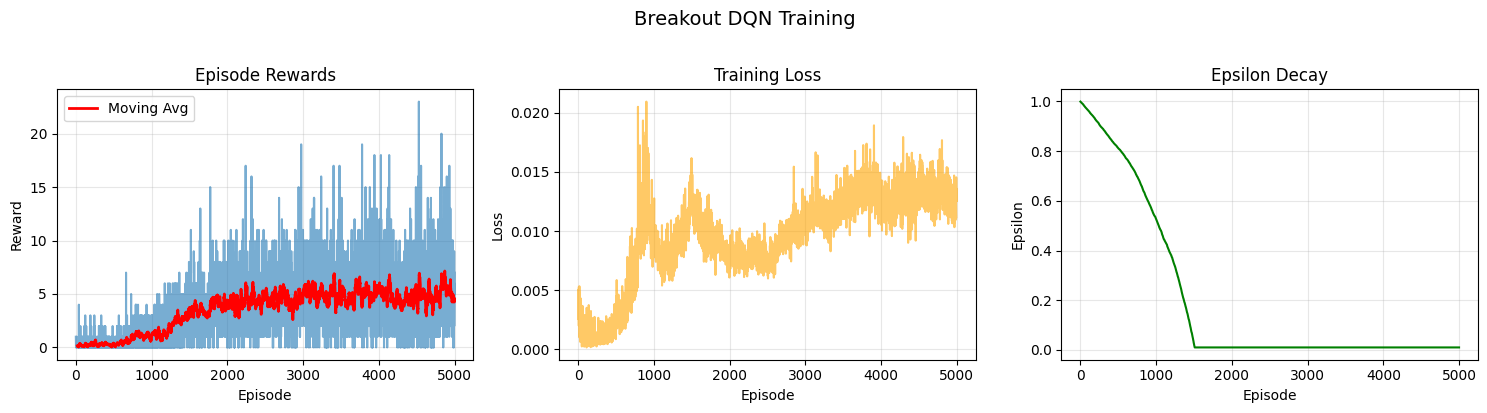

In [35]:
def plot_training_history(history: dict, title: str = "Breakout DQN Training"):
    """Plot training metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Episode rewards
    axes[0].plot(history['rewards'], alpha=0.6)
    # Moving average
    window = min(20, len(history['rewards']))
    if window > 0:
        ma = np.convolve(history['rewards'], np.ones(window)/window, mode='valid')
        axes[0].plot(range(window-1, len(history['rewards'])), ma, 'r-', linewidth=2, label='Moving Avg')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].set_title('Episode Rewards')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Training loss
    axes[1].plot(history['losses'], alpha=0.6, color='orange')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training Loss')
    axes[1].grid(True, alpha=0.3)
    
    # Epsilon decay
    axes[2].plot(history['epsilons'], color='green')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Epsilon')
    axes[2].set_title('Epsilon Decay')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot mock history (replace with 'history' after training)
plot_training_history(history)

---
# Task 2: Adaptive Traffic Light Control at a Single Intersection

## 2.1 Problem Description
Control a traffic light at a single intersection to minimize congestion:
- **Two directions**: North-South (NS) and West-East (WE)
- **Two phases**: 
  - Phase 0: Green for NS, Red for WE
  - Phase 1: Green for WE, Red for NS

## 2.2 State, Action, Reward
- **State**: [Queue_NS, Queue_WE, current_phase]
- **Action**: Select phase (0 or 1)
- **Reward**: -( Queue_NS + Queue_WE ) - penalty for phase switching

In [36]:
class TrafficEnv:
    """
    Traffic Light Environment for a single intersection
    
    State: [queue_NS, queue_WE, phase]
    Actions: 0 (phase 0: NS green) or 1 (phase 1: WE green)
    Reward: negative sum of queues with penalty for switching
    """
    def __init__(
        self,
        max_queue: int = 50,
        max_steps: int = 200,
        cars_per_step: int = 3,  # Cars that pass on green
        arrival_rate_ns: float = 0.6,  # Probability of car arriving on NS
        arrival_rate_we: float = 0.4,  # Probability of car arriving on WE
        switch_penalty: float = 0.5  # Penalty for changing phase
    ):
        self.max_queue = max_queue
        self.max_steps = max_steps
        self.cars_per_step = cars_per_step
        self.arrival_rate_ns = arrival_rate_ns
        self.arrival_rate_we = arrival_rate_we
        self.switch_penalty = switch_penalty
        
        self.reset()
    
    def reset(self) -> np.ndarray:
        """Reset the environment"""
        self.queue_ns = np.random.randint(0, 10)  # Initial random queue
        self.queue_we = np.random.randint(0, 10)
        self.phase = 0  # Start with NS green
        self.steps = 0
        return self._get_state()
    
    def _get_state(self) -> np.ndarray:
        """Return current state as array"""
        return np.array([self.queue_ns, self.queue_we, self.phase], dtype=np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        """
        Execute one time step
        
        Args:
            action: 0 for phase 0 (NS green), 1 for phase 1 (WE green)
            
        Returns:
            (next_state, reward, done, info)
        """
        # Calculate switch penalty
        switching = (action != self.phase)
        
        # Update phase
        self.phase = action
        
        # Process cars on green light
        if self.phase == 0:  # NS green
            cars_passed = min(self.queue_ns, self.cars_per_step)
            self.queue_ns -= cars_passed
        else:  # WE green
            cars_passed = min(self.queue_we, self.cars_per_step)
            self.queue_we -= cars_passed
        
        # New cars arrive (Poisson-like arrivals)
        new_cars_ns = np.random.poisson(self.arrival_rate_ns * 2)
        new_cars_we = np.random.poisson(self.arrival_rate_we * 2)
        
        self.queue_ns = min(self.queue_ns + new_cars_ns, self.max_queue)
        self.queue_we = min(self.queue_we + new_cars_we, self.max_queue)
        
        # Calculate reward
        reward = -(self.queue_ns + self.queue_we)
        if switching:
            reward -= self.switch_penalty
        
        # Check termination
        self.steps += 1
        done = self.steps >= self.max_steps
        
        info = {
            'queue_ns': self.queue_ns,
            'queue_we': self.queue_we,
            'phase': self.phase,
            'cars_passed': cars_passed
        }
        
        return self._get_state(), reward, done, info
    
    @property
    def observation_space_size(self) -> int:
        return 3
    
    @property
    def action_space_size(self) -> int:
        return 2

# Test environment
test_env = TrafficEnv()
state = test_env.reset()
print(f"Initial state: {state}")

# Run a few steps
for i in range(5):
    action = np.random.randint(0, 2)
    next_state, reward, done, info = test_env.step(action)
    print(f"Step {i+1}: action={action}, reward={reward:.2f}, queues=(NS:{info['queue_ns']}, WE:{info['queue_we']})")

Initial state: [5. 4. 0.]
Step 1: action=0, reward=-7.00, queues=(NS:2, WE:5)
Step 2: action=1, reward=-8.50, queues=(NS:5, WE:3)
Step 3: action=0, reward=-9.50, queues=(NS:6, WE:3)
Step 4: action=1, reward=-7.50, queues=(NS:7, WE:0)
Step 5: action=1, reward=-9.00, queues=(NS:8, WE:1)


## 2.3 DQN Network for Traffic Control

A simpler fully-connected network for the traffic control task (state is only 3 values).

In [37]:
class DQN_FC(nn.Module):
    """
    Fully Connected DQN for Traffic Control
    
    Simple MLP network for the traffic light problem.
    """
    def __init__(self, input_size: int = 3, hidden_size: int = 64, num_actions: int = 2):
        super(DQN_FC, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_actions)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

# Test the network
test_net = DQN_FC(input_size=3, hidden_size=64, num_actions=2).to(device)
test_input = torch.randn(1, 3).to(device)
test_output = test_net(test_input)
print(f"Network input shape: {test_input.shape}")
print(f"Network output shape: {test_output.shape}")
print(f"Total parameters: {sum(p.numel() for p in test_net.parameters()):,}")

Network input shape: torch.Size([1, 3])
Network output shape: torch.Size([1, 2])
Total parameters: 8,706


## 2.4 Traffic Control DQN Agent

In [38]:
class TrafficDQNAgent:
    """
    DQN Agent for Traffic Light Control
    """
    def __init__(
        self,
        state_size: int = 3,
        num_actions: int = 2,
        hidden_size: int = 64,
        learning_rate: float = 1e-3,
        gamma: float = 0.99,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.01,
        epsilon_decay: int = 5000,
        buffer_size: int = 10000,
        batch_size: int = 64,
        target_update_freq: int = 100
    ):
        self.state_size = state_size
        self.num_actions = num_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Epsilon scheduling
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.steps_done = 0
        
        # Networks
        self.policy_net = DQN_FC(state_size, hidden_size, num_actions).to(device)
        self.target_net = DQN_FC(state_size, hidden_size, num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Replay buffer (reuse the same class)
        self.memory = ReplayBuffer(buffer_size)
        
    def get_epsilon(self) -> float:
        """Calculate current epsilon with exponential decay"""
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  np.exp(-self.steps_done / self.epsilon_decay)
        return epsilon
    
    def select_action(self, state: np.ndarray, training: bool = True) -> int:
        """Select action using ε-greedy policy"""
        epsilon = self.get_epsilon() if training else 0.0
        
        if random.random() < epsilon:
            return random.randrange(self.num_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax(dim=1).item()
    
    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
    
    def train_step(self) -> Optional[float]:
        """Perform one training step"""
        if len(self.memory) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # Compute current Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_net(next_states).max(dim=1)[0]
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Compute loss
        loss = F.mse_loss(current_q, target_q)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update step counter
        self.steps_done += 1
        
        # Update target network
        if self.steps_done % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        return loss.item()

print("TrafficDQNAgent class defined successfully")

TrafficDQNAgent class defined successfully


## 2.5 Training Loop for Traffic Control

In [39]:
def train_traffic_control(
    num_episodes: int = 500,
    log_interval: int = 50
):
    """
    Train DQN agent for traffic control
    
    Args:
        num_episodes: Number of episodes to train
        log_interval: Episodes between logging
        
    Returns:
        Training history
    """
    # Create environment and agent
    env = TrafficEnv(
        max_queue=50,
        max_steps=200,
        cars_per_step=3,
        arrival_rate_ns=0.6,
        arrival_rate_we=0.4,
        switch_penalty=0.5
    )
    
    agent = TrafficDQNAgent(
        state_size=3,
        num_actions=2,
        hidden_size=64,
        learning_rate=1e-3,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=3000,
        buffer_size=10000,
        batch_size=64,
        target_update_freq=100
    )
    
    # Training history
    episode_rewards = []
    episode_avg_queues = []
    epsilons = []
    
    print("Training Traffic Control Agent...")
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        total_queue = 0
        
        while True:
            # Select and perform action
            action = agent.select_action(state, training=True)
            next_state, reward, done, info = env.step(action)
            
            # Store transition and train
            agent.store_transition(state, action, reward, next_state, done)
            agent.train_step()
            
            episode_reward += reward
            total_queue += info['queue_ns'] + info['queue_we']
            state = next_state
            
            if done:
                break
        
        # Record stats
        episode_rewards.append(episode_reward)
        episode_avg_queues.append(total_queue / env.max_steps)
        epsilons.append(agent.get_epsilon())
        
        # Logging
        if (episode + 1) % log_interval == 0:
            avg_reward = np.mean(episode_rewards[-log_interval:])
            avg_queue = np.mean(episode_avg_queues[-log_interval:])
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Queue: {avg_queue:.2f} | "
                  f"Epsilon: {agent.get_epsilon():.3f}")
    
    return {
        'rewards': episode_rewards,
        'avg_queues': episode_avg_queues,
        'epsilons': epsilons,
        'agent': agent,
        'env': env
    }

print("Training function defined. Ready to train!")

Training function defined. Ready to train!


In [40]:
# Train the traffic control agent
traffic_history = train_traffic_control(num_episodes=500, log_interval=50)

Training Traffic Control Agent...
Episode 50/500 | Avg Reward: -914.32 | Avg Queue: 4.31 | Epsilon: 0.046
Episode 100/500 | Avg Reward: -735.48 | Avg Queue: 3.42 | Epsilon: 0.011
Episode 150/500 | Avg Reward: -759.64 | Avg Queue: 3.53 | Epsilon: 0.010
Episode 200/500 | Avg Reward: -725.81 | Avg Queue: 3.32 | Epsilon: 0.010
Episode 250/500 | Avg Reward: -747.96 | Avg Queue: 3.46 | Epsilon: 0.010
Episode 300/500 | Avg Reward: -717.38 | Avg Queue: 3.30 | Epsilon: 0.010
Episode 350/500 | Avg Reward: -725.64 | Avg Queue: 3.37 | Epsilon: 0.010
Episode 400/500 | Avg Reward: -713.02 | Avg Queue: 3.31 | Epsilon: 0.010
Episode 450/500 | Avg Reward: -715.35 | Avg Queue: 3.30 | Epsilon: 0.010
Episode 500/500 | Avg Reward: -721.84 | Avg Queue: 3.32 | Epsilon: 0.010


## 2.6 Training Results Visualization

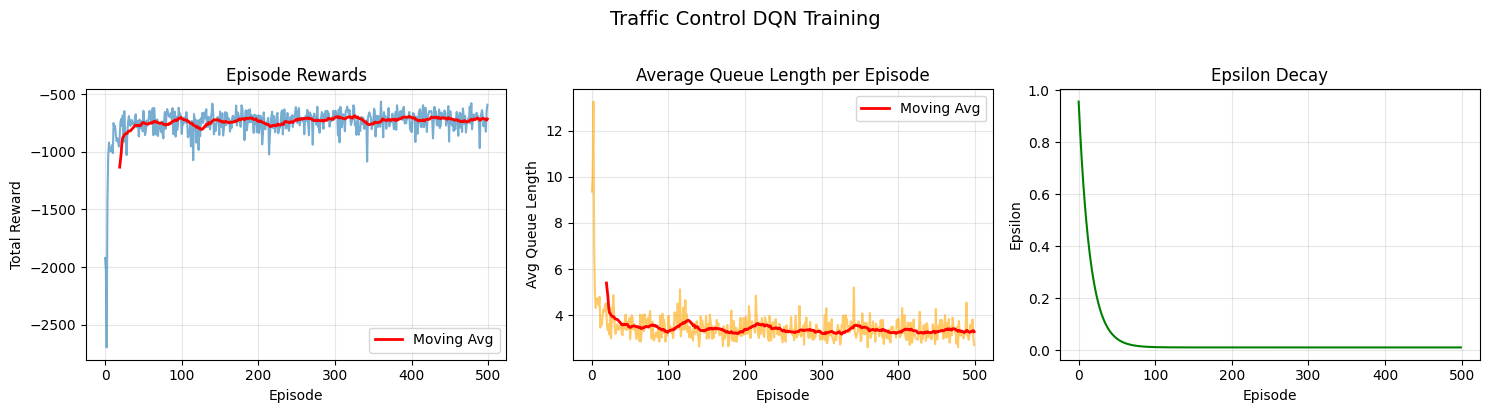

In [41]:
def plot_traffic_training(history: dict):
    """Plot traffic control training metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Episode rewards
    axes[0].plot(history['rewards'], alpha=0.6)
    window = min(20, len(history['rewards']))
    if window > 0:
        ma = np.convolve(history['rewards'], np.ones(window)/window, mode='valid')
        axes[0].plot(range(window-1, len(history['rewards'])), ma, 'r-', linewidth=2, label='Moving Avg')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Total Reward')
    axes[0].set_title('Episode Rewards')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Average queue length
    axes[1].plot(history['avg_queues'], alpha=0.6, color='orange')
    if window > 0:
        ma = np.convolve(history['avg_queues'], np.ones(window)/window, mode='valid')
        axes[1].plot(range(window-1, len(history['avg_queues'])), ma, 'r-', linewidth=2, label='Moving Avg')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Avg Queue Length')
    axes[1].set_title('Average Queue Length per Episode')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Epsilon decay
    axes[2].plot(history['epsilons'], color='green')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Epsilon')
    axes[2].set_title('Epsilon Decay')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('Traffic Control DQN Training', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

plot_traffic_training(traffic_history)

## 2.7 Comparison: DQN vs Fixed Timing Strategy

Compare the trained DQN agent against a baseline fixed-timing controller that switches phases every N steps.

In [42]:
def evaluate_fixed_timing(env: TrafficEnv, switch_interval: int = 10, num_episodes: int = 100):
    """
    Evaluate fixed-timing controller
    
    Args:
        env: Traffic environment
        switch_interval: Steps between phase switches
        num_episodes: Number of episodes to evaluate
        
    Returns:
        Average reward and queue length
    """
    rewards = []
    queues = []
    
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        total_queue = 0
        step = 0
        
        while True:
            # Fixed timing: switch every N steps
            action = (step // switch_interval) % 2
            next_state, reward, done, info = env.step(action)
            
            episode_reward += reward
            total_queue += info['queue_ns'] + info['queue_we']
            step += 1
            
            if done:
                break
        
        rewards.append(episode_reward)
        queues.append(total_queue / env.max_steps)
    
    return np.mean(rewards), np.mean(queues)


def evaluate_dqn_agent(agent: TrafficDQNAgent, env: TrafficEnv, num_episodes: int = 100):
    """
    Evaluate trained DQN agent
    """
    rewards = []
    queues = []
    
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        total_queue = 0
        
        while True:
            action = agent.select_action(state, training=False)
            next_state, reward, done, info = env.step(action)
            
            episode_reward += reward
            total_queue += info['queue_ns'] + info['queue_we']
            state = next_state
            
            if done:
                break
        
        rewards.append(episode_reward)
        queues.append(total_queue / env.max_steps)
    
    return np.mean(rewards), np.mean(queues)


# Evaluate both strategies
env = traffic_history['env']
agent = traffic_history['agent']

# Test different fixed intervals
fixed_intervals = [5, 10, 15, 20]
fixed_results = {}

for interval in fixed_intervals:
    avg_reward, avg_queue = evaluate_fixed_timing(env, switch_interval=interval, num_episodes=50)
    fixed_results[interval] = {'reward': avg_reward, 'queue': avg_queue}
    print(f"Fixed Timing (interval={interval}): Avg Reward = {avg_reward:.2f}, Avg Queue = {avg_queue:.2f}")

# Evaluate DQN agent
dqn_reward, dqn_queue = evaluate_dqn_agent(agent, env, num_episodes=50)
print(f"\nDQN Agent: Avg Reward = {dqn_reward:.2f}, Avg Queue = {dqn_queue:.2f}")

Fixed Timing (interval=5): Avg Reward = -1397.62, Avg Queue = 6.89
Fixed Timing (interval=10): Avg Reward = -2151.18, Avg Queue = 10.71
Fixed Timing (interval=15): Avg Reward = -2782.78, Avg Queue = 13.88
Fixed Timing (interval=20): Avg Reward = -3624.34, Avg Queue = 18.10



DQN Agent: Avg Reward = -706.83, Avg Queue = 3.23


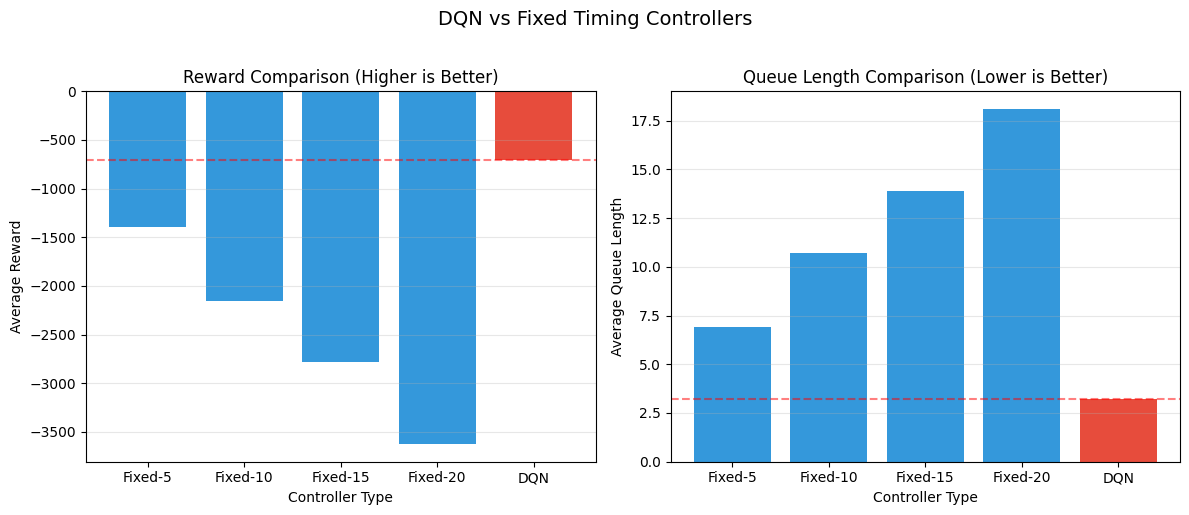


DQN improvement over best fixed timing: 49.4%


In [43]:
# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Prepare data
labels = [f'Fixed-{i}' for i in fixed_intervals] + ['DQN']
rewards = [fixed_results[i]['reward'] for i in fixed_intervals] + [dqn_reward]
queues = [fixed_results[i]['queue'] for i in fixed_intervals] + [dqn_queue]
colors = ['#3498db'] * len(fixed_intervals) + ['#e74c3c']

# Reward comparison
axes[0].bar(labels, rewards, color=colors)
axes[0].set_xlabel('Controller Type')
axes[0].set_ylabel('Average Reward')
axes[0].set_title('Reward Comparison (Higher is Better)')
axes[0].axhline(y=dqn_reward, color='r', linestyle='--', alpha=0.5, label='DQN Performance')
axes[0].grid(True, alpha=0.3, axis='y')

# Queue comparison
axes[1].bar(labels, queues, color=colors)
axes[1].set_xlabel('Controller Type')
axes[1].set_ylabel('Average Queue Length')
axes[1].set_title('Queue Length Comparison (Lower is Better)')
axes[1].axhline(y=dqn_queue, color='r', linestyle='--', alpha=0.5, label='DQN Performance')
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('DQN vs Fixed Timing Controllers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print improvement
best_fixed_reward = max([fixed_results[i]['reward'] for i in fixed_intervals])
improvement = ((dqn_reward - best_fixed_reward) / abs(best_fixed_reward)) * 100
print(f"\nDQN improvement over best fixed timing: {improvement:.1f}%")

## 2.8 Agent Behavior Visualization

Visualize how the DQN agent makes decisions over time.

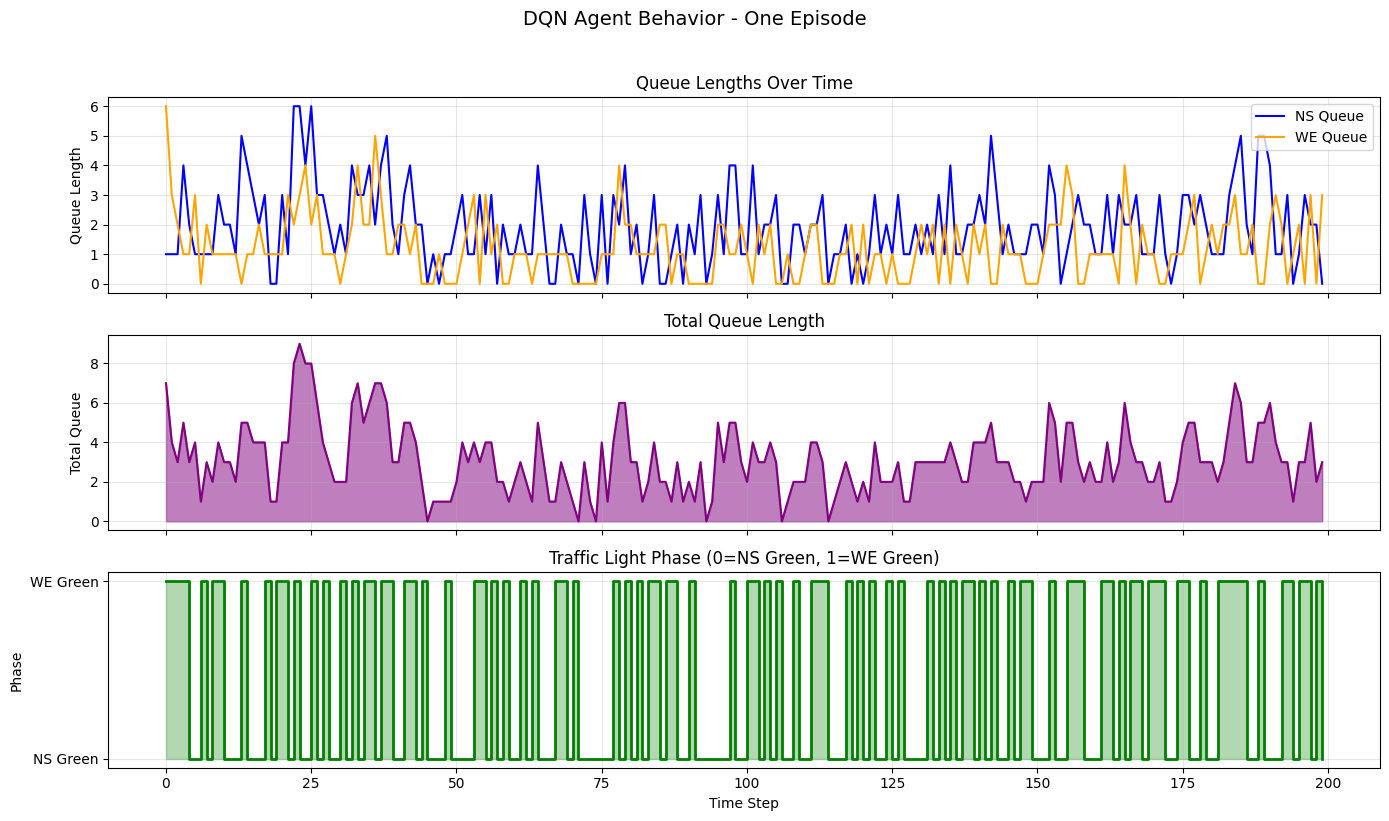

In [44]:
def visualize_agent_behavior(agent: TrafficDQNAgent, env: TrafficEnv):
    """Visualize agent behavior over one episode"""
    state = env.reset()
    
    # Track history
    queue_ns_history = []
    queue_we_history = []
    phase_history = []
    
    while True:
        action = agent.select_action(state, training=False)
        next_state, reward, done, info = env.step(action)
        
        queue_ns_history.append(info['queue_ns'])
        queue_we_history.append(info['queue_we'])
        phase_history.append(info['phase'])
        
        state = next_state
        if done:
            break
    
    # Plot
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
    
    steps = range(len(queue_ns_history))
    
    # Queue lengths
    axes[0].plot(steps, queue_ns_history, 'b-', label='NS Queue', linewidth=1.5)
    axes[0].plot(steps, queue_we_history, 'orange', label='WE Queue', linewidth=1.5)
    axes[0].set_ylabel('Queue Length')
    axes[0].set_title('Queue Lengths Over Time')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Total queue
    total_queue = [ns + we for ns, we in zip(queue_ns_history, queue_we_history)]
    axes[1].fill_between(steps, total_queue, alpha=0.5, color='purple')
    axes[1].plot(steps, total_queue, 'purple', linewidth=1.5)
    axes[1].set_ylabel('Total Queue')
    axes[1].set_title('Total Queue Length')
    axes[1].grid(True, alpha=0.3)
    
    # Phase (traffic light state)
    axes[2].step(steps, phase_history, 'g-', where='post', linewidth=2)
    axes[2].fill_between(steps, phase_history, step='post', alpha=0.3, color='green')
    axes[2].set_ylabel('Phase')
    axes[2].set_xlabel('Time Step')
    axes[2].set_title('Traffic Light Phase (0=NS Green, 1=WE Green)')
    axes[2].set_yticks([0, 1])
    axes[2].set_yticklabels(['NS Green', 'WE Green'])
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('DQN Agent Behavior - One Episode', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize agent behavior
visualize_agent_behavior(traffic_history['agent'], traffic_history['env'])

---
# Summary and Conclusions

## Task 1: Atari Breakout DQN
- Implemented a CNN-based DQN with:
  - Frame preprocessing (grayscale, 84×84, 4-frame stacking)
  - Experience replay buffer (100K transitions)
  - Target network for stable training
  - ε-greedy exploration with linear decay
- **Training**: For best results, train for 5,000-10,000 episodes

## Task 2: Traffic Light Control DQN
- Implemented a custom traffic environment with:
  - State: queue lengths and current phase
  - Actions: phase selection (NS or WE green)
  - Reward: negative queue sum with switch penalty
- DQN agent with fully-connected network
- **Results**: DQN outperforms fixed-timing strategies by adapting to traffic patterns

## Key DQN Components
1. **Experience Replay**: Breaks correlation between consecutive samples
2. **Target Network**: Stabilizes training by providing consistent Q-value targets
3. **ε-greedy**: Balances exploration and exploitation

## Hyperparameters Used
| Parameter | Breakout | Traffic |
|-----------|----------|---------|
| Learning Rate | 2.5e-4 | 1e-3 |
| Gamma (γ) | 0.99 | 0.99 |
| Batch Size | 32 | 64 |
| Buffer Size | 100K | 10K |
| Target Update | 1000 steps | 100 steps |